# Diagonal permutation

Our goal in this notebook is 

1. to create a distance matrix that reflects the distances between particular quarters of the Billboard Hot 100, 1960-2010, and measure Foote novelty on that matrix

2. to create a null model that will allow us to assess the significance of those Foote novelty measurements.

The underlying dataset is borrowed from Mauch et al., "The Evolution of Popular Music," but the methods we develop here can, we hope, be adapted to other domains.

This notebook was written up by Ted Underwood, in response to an insight about the appropriate null model suggested by Yuancheng Zhu.

We begin by reading in the data, which consists of principal components of a topic model that identifies "harmonic and timbral topics" in the music. The appropriateness of that dimension-reduction is not our central concern here; we're interested in what happens _after_ you've got points on a timeline characterized in some kind of dimension space.

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import csv, random
import numpy as np
from scipy import spatial

pcafields = ['PC' + str(x) for x in range(1,15)]
# Here we just create a list of strings that will
# correspond to field names in the data provided
# by Mauch et al.

pca = list()
with open('nb/quarterlypca.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        newpcarow = []
        for field in pcafields:
            newpcarow.append(float(row[field]))
        pca.append(newpcarow)

pca = np.array(pca)
print(pca.shape)

(200, 14)


Now we have an array of 200 observations, each of which is characterized by 14 variables. Let's define a function to create a distance matrix by comparing each observation against all the others.

In [58]:
def distance_matrix(pca):
    observations, dimensions = pca.shape
    distmat = np.zeros((observations, observations))
    for i in range(observations):
        for j in range(observations):
            dist = spatial.distance.cosine(pca[i], pca[j])
            distmat[i, j] = dist
    return distmat

d = distance_matrix(pca)    

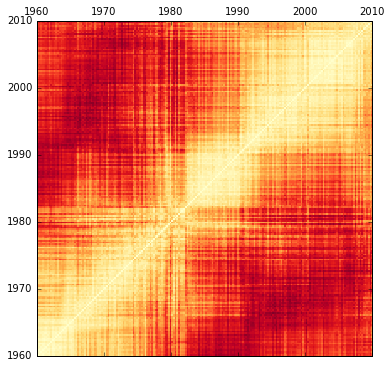

In [78]:
plt.rcParams["figure.figsize"] = [9.0, 6.0]
plt.matshow(d, origin = 'lower', cmap = plt.cm.YlOrRd, extent = [1960, 2010, 1960, 2010])
plt.show()

So far so good; that closely resembles the distance matrix seen in Mauch et al. Now let's calculate Foote novelties. There are two parts to this process. Calculating Foote novelties is done by sliding a smaller matrix along the diagonal of the distance matrix and then multiplying elementwise. 

So first we have to create the smaller matrix, using the function make_foote. Then we pass that as a parameter to the function foote_novelty. Passing matrices of different size will calculate different windows of similarity. Below we define these two functions, and then calculate Foote novelties for a window with a five-year half-width.

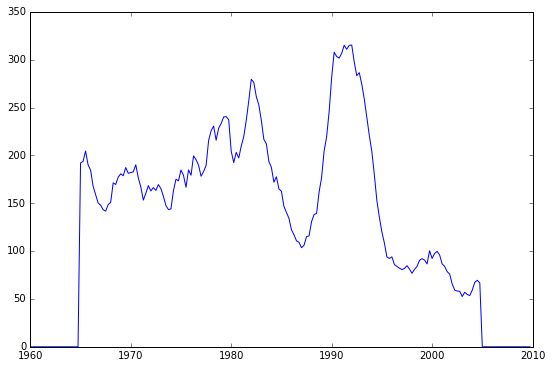

Max novelty for a five-year half-width: 315.452941139


In [60]:
def make_foote(quart):
    tophalf = [-1] * quart + [1] * quart
    bottomhalf = [1] * quart + [-1] * quart
    foote = list()
    for i in range(quart):
        foote.append(tophalf)
    for i in range(quart):
        foote.append(bottomhalf)
    foote = np.array(foote)
    return foote

foote5 = make_foote(20)
# This gives us a Foote matrix with a five-year half-width.
# 5 becomes 20 because the underlying dataset has four
# "quarters" of data in each year.

def foote_novelty(distmat, foote):
    axis1, axis2 = distmat.shape
    assert axis1 == axis2
    distsize = axis1
    
    axis1, axis2 = foote.shape
    assert axis1 == axis2
    halfwidth = axis1 / 2
    
    novelties = []
    
    for i in range(distsize):
        
        start = int(i - halfwidth)
        end = int(i + halfwidth)
        
        if start < 0 or end > (distsize - 1):
            novelties.append(0)
        else:
            novelties.append(np.sum(foote * distmat[start: end, start: end]))
    
    return novelties

def getyears():
    years = []
    for i in range(200):
        years.append(1960 + i*0.25)
    return years

years = getyears()

novelties = foote_novelty(d, foote5)
plt.plot(years, novelties)
plt.show()
print("Max novelty for a five-year half-width: " + str(np.max(novelties)))

## Testing significance

Okay, now we have functions that can test Foote novelty in a distance matrix. But how do we know whether the apparent peaks and troughs in the plot above represent statistically significant variation?

We need a "null model": a way of producing distance matrices that represent a random version of our data. On the other hand, we want to get the _right kind_ of randomness. Foote novelty is sensitive to the distribution of values relative to the central diagonal timeline. So if we produce a "random model" where those values are evenly distributed, for instance by randomizing the underlying data and then calculating a distance matrix on it ...

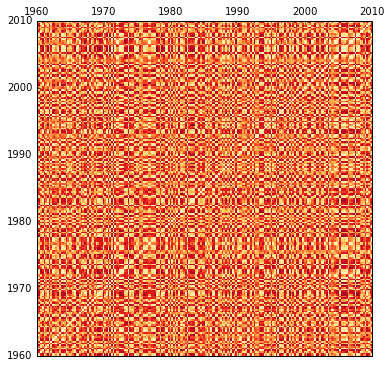

In [79]:
randomized = np.array(pca)
np.random.shuffle(randomized)
randdist = distance_matrix(randomized)
plt.matshow(randdist, origin = 'lower', cmap = plt.cm.YlOrRd, extent = [1960, 2010, 1960, 2010])
plt.show()

That is far from an apples-to-apples null model. The problem is that the original data was _sequential,_ so distances between nearby points were usually smaller than distances between remote ones. That created the central "yellow path" running from lower left to upper right, following the diagonal timeline of quarters compared-to-themselves.

We need a better null model. The one below relies on a suggestion from Yuancheng Zhu, which was to permute values of the original distance matrix, and do it only _within_ diagonals. That way comparisons across a distance of (say) two quarters are permuted only with other two-quarter comparisons. I've added a small twist, which is to try to preserve the same underlying permutation for every diagonal (as far as possible), keying it to the x or y value for each point. That way vertically and horizontally-adjacent "pixels" of the matrix retain the same kind of "cross-hatched" correlation with each other that we saw in the original matrix. It's not perfect, but it's a reasonable approximation of a dataset where change is sequential, but randomly distributed.

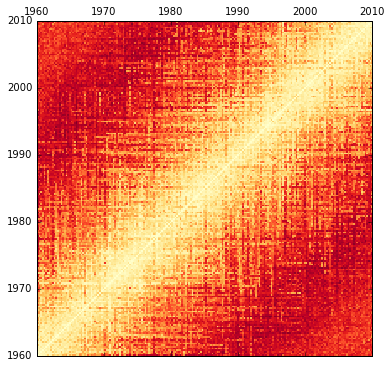

In [77]:
def diagonal_permute(d):
    newmat = np.zeros((200, 200))
    
    # We create one randomly-permuted list of integers called "translate"
    # that is going to be used for the whole matrix.
    
    translate = [i for i in range(200)]
    random.shuffle(translate)
    
    # Because distances matrices are symmetrical, we're going to be doing
    # two diagonals at once each time. We only need one set of values
    # (because symmetrical) but we need two sets of indices in the original
    # matrix so we know where to put the values back when we're done permuting
    # them.
    
    for i in range(0, 200):
        indices1 = []
        indices2 = []
        values = []
        for x in range(200):
            y1 = x + i
            y2 = x - i
            if y1 >= 0 and y1 < 200:
                values.append(d[x, y1])
                indices1.append((x, y1))
            if y2 >= 0 and y2 < 200:
                indices2.append((x, y2))
        
        # Okay, for each diagonal, we permute the values.
        # We'll store the permuted values in newvalues.
        # We also check to see how many values we have,
        # so we can randomly select values if needed.
        
        newvalues = []
        lenvals = len(values)
        vallist = [i for i in range(lenvals)]
        
        for indexes, value in zip(indices1, values):
            x, y = indexes
            
            xposition = translate[x]
            yposition = translate[y]
            
            # We're going to key the randomization to the x, y
            # values for each point, insofar as that's possible.
            # Doing this will ensure that specific horizontal and
            # vertical lines preserve the dependence relations in
            # the original matrix.
            
            # But the way we're doing this is to use the permuted
            # x (or y) values to select an index in our list of
            # values in the present diagonal, and that's only possible
            # if the list is long enough to permit it. So we check:
            
            if xposition < 0 and yposition < 0:
                position = random.choice(vallist)
            elif xposition >= lenvals and yposition >= lenvals:
                position = random.choice(vallist)
            elif xposition < 0:
                position = yposition
            elif yposition < 0:
                position = xposition
            elif xposition >= lenvals:
                position = yposition
            elif yposition >= lenvals:
                position = xposition
            else:
                position = random.choice([xposition, yposition])
                # If either x or y could be used as an index, we
                # select randomly.
            
            # Whatever index was chosen, we use it to select a value
            # from our diagonal. 
            
            newvalues.append(values[position])
            
        values = newvalues
        
        # Now we lay down (both versions of) the diagonal in the
        # new matrix.
        
        for idxtuple1, idxtuple2, value in zip(indices1, indices2, values):
            x, y = idxtuple1
            newmat[x, y] = value
            x, y = idxtuple2
            newmat[x, y] = value
    
    return newmat

newmat = diagonal_permute(d)
plt.matshow(newmat, origin = 'lower', cmap = plt.cm.YlOrRd, extent = [1960, 2010, 1960, 2010])
plt.show()

What if we now try assessing foote novelties on this randomized matrix? What maximum or minimum value will we get?

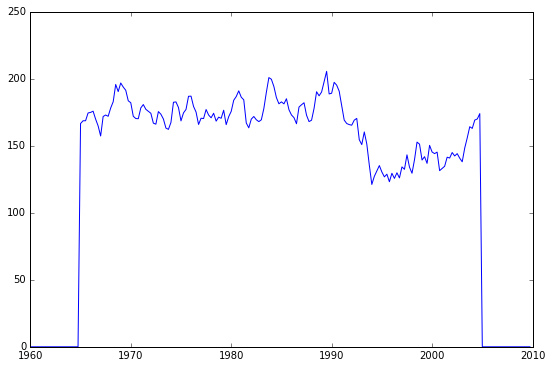

Max novelty for five-year half-width:205.683530092
Min novelty for five-year half-width:121.225140587


In [63]:
novelties = foote_novelty(newmat, foote5)
years = getyears()
plt.plot(years, novelties)
plt.show()
print("Max novelty for five-year half-width:" + str(np.max(novelties)))

def zeroless(sequence):
    newseq = []
    for element in sequence:
        if element > 0.01:
            newseq.append(element)
    return newseq
print("Min novelty for five-year half-width:" + str(np.min(zeroless(novelties))))

By repeatedly running that test, we can assess the likely range of random variation. It turns out that there are only two "peaks" in the dataset that are clearly and consistently p < 0.05: one in the early eighties, and one in the earl nineties. The _slowing_ of change at the end of the nineties is also statistically significant.

223.05107496
106.984401519


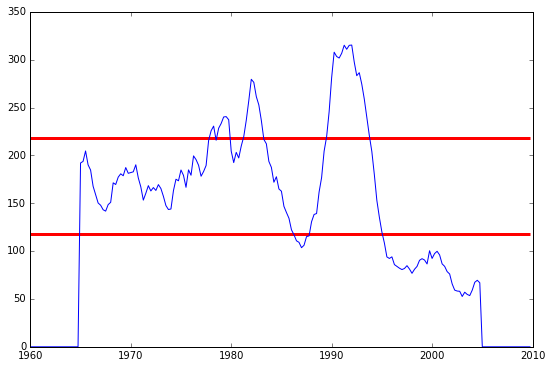

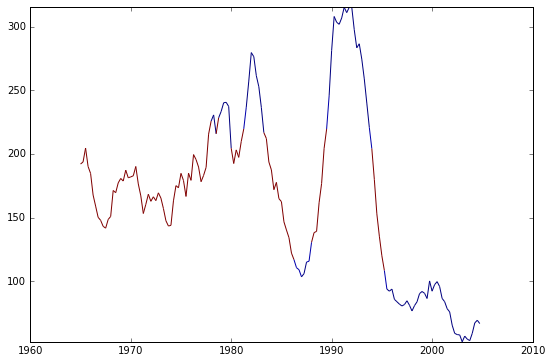

In [64]:
def permute_test(distmatrix, yrwidth):
    footematrix = make_foote(4 * yrwidth)
    actual_novelties = foote_novelty(distmatrix, footematrix)
    
    permuted_peaks = []
    permuted_troughs = []
    for i in range(100):
        randdist = diagonal_permute(distmatrix)
        nov = foote_novelty(randdist, footematrix)
        nov = zeroless(nov)
        permuted_peaks.append(np.max(nov))
        permuted_troughs.append(np.min(nov))
    permuted_peaks.sort(reverse = True)
    permuted_troughs.sort(reverse = True)
    threshold05 = permuted_peaks[4]
    threshold01 = permuted_peaks[0]
    threshold95 = permuted_troughs[94]
    threshold99 = permuted_troughs[99]
    print(threshold01)
    print(threshold99)
    
    significance = np.ones(len(actual_novelties))
    for idx, novelty in enumerate(actual_novelties):

        if novelty > threshold05 or novelty < threshold95:
            significance[idx] = 0.049
        if novelty > threshold01 or novelty < threshold99:
            significance[idx] = 0.009
    
    return actual_novelties, significance, threshold01, threshold05, threshold95, threshold99

def colored_segments(novelties, significance):
    x = []
    y = []
    t = []
    idx = 0
    for nov, sig in zip(novelties, significance):
        if nov > 1:
            x.append(idx/4 + 1960)
            y.append(nov)
            t.append(sig)
        idx += 1
        
    x = np.array(x)
    y = np.array(y)
    t = np.array(t)
    
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(t)
    
    return lc, x, y

novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(d, 5)
years = []
for i in range(200):
    years.append(1960 + i*0.25)
plt.plot(years, novelties)
startpoint = years[0]
endpoint = years[199]
plt.hlines(threshold05, startpoint, endpoint, 'r', linewidth = 3)
plt.hlines(threshold95, startpoint, endpoint, 'r', linewidth = 3)
plt.show()

lc, x, y = colored_segments(novelties, significance)

plt.gca().add_collection(lc) # add the collection to the plot
plt.xlim(1960, 2010) # line collections don't auto-scale the plot
plt.ylim(y.min(), y.max())
plt.show()
    

## Visualization

Neither of the methods used above are terribly good as visualizations, so let's come up with a slightly better version: getting rid of the misleading "edges" and overplotting points to indicate the number of significant observations in particular periods.

223.263870889
104.057400927


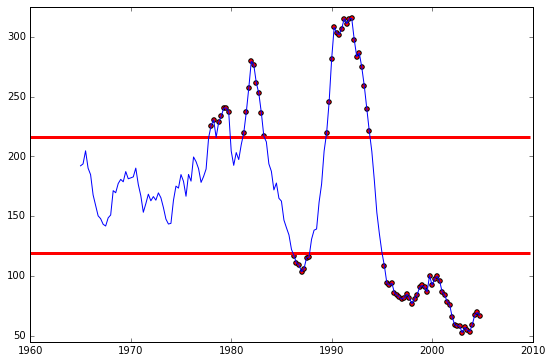

In [65]:
def zeroless_seq(thefilter, filtereda, filteredb):
    thefilter = np.array(thefilter)
    filtereda = np.array(filtereda)
    filteredb = np.array(filteredb)
    filtereda = filtereda[thefilter > 0]
    filteredb = filteredb[thefilter > 0]
    thefilter = thefilter[thefilter > 0]
    return thefilter, filtereda, filteredb

plt.clf()
plt.axis([1960, 2010, 45, 325])
novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(d, 5)
novelties, years, significance = zeroless_seq(novelties, getyears(), significance)
yplot = novelties[significance < 0.05]
xplot = years[significance < 0.05]
plt.scatter(xplot, yplot, c = 'red')
plt.plot(years, novelties)
years = getyears()
startpoint = years[0]
endpoint = years[199]
plt.hlines(threshold05, startpoint, endpoint, 'r', linewidth = 3)
plt.hlines(threshold95, startpoint, endpoint, 'r', linewidth = 3)
plt.show()

## Effect size

What about the effect size? Foote novelty is not really a direct measurement of the pace of change.

One way to measure it is, to accept the periods defined by the visualization above, and compare change across each of those periods. 

So, for instance, the significant points in the second peak range from 1990 to 1994, and the lowest trough is roughly 2001 to 2005. We can divide each of those periods in half, and compare the first half to the second half. It looks like Mauch et al. are roughly right about effect size: it's a sixfold difference.

In [66]:
def pacechange(startdate, enddate, pca):
    years = getyears()
    startidx = years.index(startdate)
    endidx = years.index(enddate)
    midpoint = int((startidx + endidx)/2)
    firsthalf = np.zeros(14)
    for i in range(startidx,midpoint):
        firsthalf = firsthalf + pca[i]
    secondhalf = np.zeros(14)
    for i in range(midpoint, endidx):
        secondhalf = secondhalf + pca[i]
    return spatial.distance.cosine(firsthalf, secondhalf)

print(pacechange(1990, 1994, pca))
print(pacechange(2001, 2005, pca))

0.183038360754
0.0313319960388


We can also get a mean value for the whole run.

In [67]:
thesum = 0
theobservations = 0
for i in range(1960, 2006):
    theobservations += 1
    thesum += pacechange(i, i+4, pca)
print(thesum / theobservations)

0.107015993072


## Comparing multiple scales at once

If we wanted to, we could also overplot multiple scales of comparison with different half-widths. Doing this reveals one of the nice things about the "Foote novelty" method, which is that it remains relatively stable as you vary scales of comparison. The same cannot be said, for instance, of changepoint analysis!

In the cell below we've overplotted three-year, four-year, and five-year Foote novelties, highlighting in each case the specific quarters that have two-tailed p values lower than 0.05.

59.1723416638
11.7990910769
126.213554091
47.6389641208
224.588284471
115.5381266


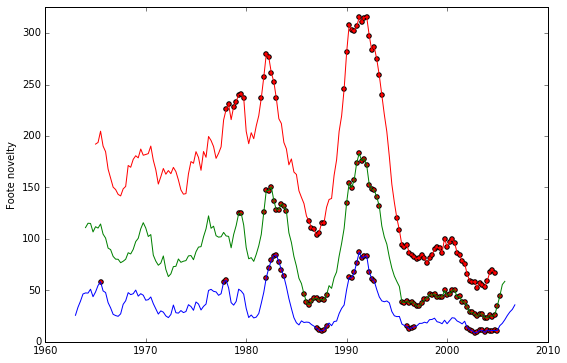

In [76]:
plt.axis([1960, 2010, 0, y.max() + 10])
    
def add_scatter(d, width):
    novelties, significance, threshold01, threshold05, threshold95, threshold99 = permute_test(d, width)
    novelties, years, significance = zeroless_seq(novelties, getyears(), significance)
    yplot = novelties[significance < 0.05]
    xplot = years[significance < 0.05]
    plt.scatter(xplot, yplot, c = 'red')
    plt.plot(years, novelties)

add_scatter(d, 3)
add_scatter(d, 4)
add_scatter(d, 5)
plt.ylabel('Foote novelty')
plt.show()